In [1]:
import numpy as np
import matplotlib.pyplot as plt
import celerite as celery
celery.__version__

'0.4.0'

In [2]:
np.random.seed(42)
%matplotlib inline

#### set up the power spectrum:

In [3]:
a_max = 0.55 # amplitude of central mode in m/s
nu_max = 3.1e-3 # peak frequency in Hz
c_env = 0.331e-3 # envelope width in Hz
delta_nu = 0.00013 # Hz
freq_grid = np.arange(nu_max - 0.001, nu_max + 0.001, delta_nu) # magic numbers for l=0 modes
l_grid = np.append(np.zeros_like(freq_grid), np.ones_like(freq_grid))
freq_grid = np.append(freq_grid, freq_grid)
freq_grid += l_grid * 0.5 * delta_nu # add l=1 modes
omega_grid = 2.*np.pi*freq_grid # angular frequencies
amp_grid = a_max**2 * np.exp(-(freq_grid-nu_max)**2/(2.*c_env**2)) # amplitudes in m/s
amp_grid -= 0.4 * amp_grid * l_grid # l=1 modes

In [4]:
gamma = 1. / (2 * 24. * 60. * 60.) # s^-1 ; 2-day damping timescale
dt = 50. # seconds - approximate Nyquist sampling
driving_amp_grid = np.sqrt(amp_grid * gamma * dt)

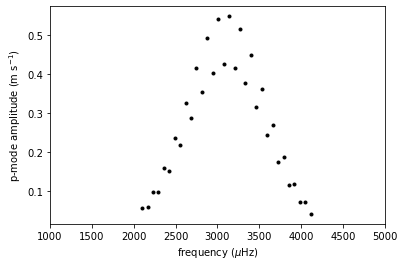

In [5]:
# check it:
plt.plot(freq_grid * 1.e6, np.sqrt(amp_grid), 'k.')
plt.ylabel('p-mode amplitude (m s$^{-1}$)')
plt.xlabel('frequency ($\mu$Hz)')
plt.xlim([1000,5000]);

In [6]:
# celery-friendly:
log_S0_grid = [np.log(d**2 / (dt * o)) for o,d in zip(omega_grid,driving_amp_grid)]  # velocity variance * kicks / radian

#### generate dense grid of RVs with GP model:

In [7]:
# time grid:
dt = 60. # seconds
timespan = 10. * 365. # days
ts = dt * np.arange(timespan * 24. * 3600. / dt)

In [8]:
# GP kernel:
kernel = None
for o,lS in zip(omega_grid,log_S0_grid):
    if kernel is None:
        kernel = celery.terms.SHOTerm(lS, np.log(o/gamma), np.log(o))
    else:
        kernel += celery.terms.SHOTerm(lS, np.log(o/gamma), np.log(o)) 

In [9]:
# run GP:
gp = celery.GP(kernel)
gp.compute(ts)
rvs = gp.sample()

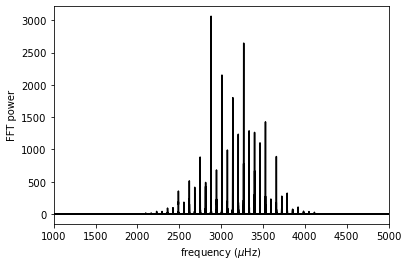

In [10]:
# check the power spectrum:
powers = np.fft.fft(rvs)
real_powers = (powers * powers.conj()).real
fs = np.fft.fftfreq(rvs.shape[-1]) / dt
fft = np.copy(real_powers/1e6)
plt.plot(fs*1e6, fft, 'k-')
plt.xlim([1000,5000])
plt.ylabel('FFT power')
plt.xlabel('frequency ($\mu$Hz)');

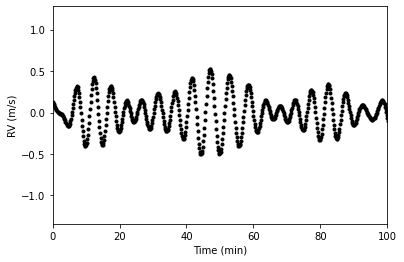

In [11]:
# check the RVs:
plt.plot(ts/60., rvs, 'k.')
plt.xlim([0, 100])
plt.xlabel('Time (min)')
plt.ylabel('RV (m/s)');